# Vehicle License Plate Detection and Recognition

If you have any trouble with any part of this notebook, please contact me at splithor1zon@protonmail.ch

## 1 License Plate Detection using Transfer Learning

### References

#### Base Code Sources:

- [YouTube tutorial](https://www.youtube.com/watch?v=0-4p_QgrdbE)
- [GitHub specific](https://github.com/nicknochnack/RealTimeAutomaticNumberPlateRecognition)
- [GitHub general](https://github.com/nicknochnack/TFODCourse)

#### Pre-trained Model References:

- [SSD paper](https://arxiv.org/pdf/1512.02325.pdf)
- [SSD review](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11)
- [MobileNet v2 paper](https://arxiv.org/pdf/1801.04381.pdf)
- [Searching for MobileNet v3](https://arxiv.org/pdf/1905.02244.pdf)

### 1.1 Prepare Environment

#### 1.1.1 Select a Pre-trained Model


In [ ]:
# SSD MobileNet v2
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

#### 1.1.2 Environment Variables

In [ ]:
import os
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

# Needed folders for the files that will be generated
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc'),
    'EXPORT_PATH':os.path.join('export')
 }
 
# Required system files 
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# OS check + create folders
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# Download selected tensorflow model and clone it into our tensorflow/model path using wget
if os.name=='nt':
    %pip install wget
    import wget

if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

#### 1.1.3 Package Installation

In [ ]:
# Install required packages (may take some time), if you still get missing package error, install it using pip install.
%pip install tensorflow tensorflow-gpu --upgrade
%pip install protobuf
%pip install matplotlib
%pip install apache-beam
%pip install avro-python3
%pip install contextlib2
%pip install Cython
%pip install lxml
%pip install pycocotools
%pip install gin-config
%pip install "google-api-python-client>=1.6.7"
%pip install "kaggle>=1.3.9"
%pip install oauth2client
%pip install opencv-python-headless
%pip install "py-cpuinfo>=3.3.0"
%pip install sacrebleu
%pip install sentencepiece
%pip install seqeval
%pip install tensorflow-addons
%pip install tensorflow-datasets
%pip install "tensorflow-hub>=0.6.0"
%pip install "tensorflow-model-optimization>=0.4.1"
%pip install "tensorflow-text~=2.8.0"
%pip install "pyyaml<6.0,>=5.1"

In [ ]:
# Verify installation
!pip list

In [ ]:
# Installs protocol buffer depending on our machine type and install Object detection
# https://developers.google.com/protocol-buffers/docs/downloads
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
# Checks if we installed correctly
# This check should end with OK and your GPU (if you have one) should be detected
# If some packages are still missing, install them using pip
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

In [ ]:
# Pull the pretrained model that we chose at the beginning (MobileNet) to do transfer learning and unzip it
# In the case of no object_detection module error please restart the kernel or PC
import object_detection
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

#### 1.1.4 Data Preparation

You need to download data separately.
- [Sample Dataset 1](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection)

Then you need to divide samples for training/testing in `.\Tensorflow\workspace\images` and place them into train/test folders respectively along with their annotations.

In [ ]:
# Creates the mapping of all the possible object we can find within the input image from the xml file searching for the object licence
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

For the next step you need to manually change the record script found at: `.\Tensorflow\scripts\generate_tfrecord.py`. Change these lines:
> int(member[4][0].text),<br>
> int(member[4][1].text),<br>
> int(member[4][2].text),<br>
> int(member[4][3].text)

to:

> int(member[5][0].text),<br>
> int(member[5][1].text),<br>
> int(member[5][2].text),<br>
> int(member[5][3].text)

In [ ]:
# Create record files.
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

In [ ]:
# Import libraries and prepare config file
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [ ]:
# Fine-tune the model configuration
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text) 

### 1.2 Model Training

In [ ]:
# Build and print the training command. (Preferably executed in console to observe progress)
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

In [ ]:
# Or execute the command here.
!{command}

### 1.3 Model Evaluation

In [ ]:
# Build and print the evaluation command. (Preferably executed in console to observe progress)
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

In [ ]:
# Or execute the command here.
!{command}

### 1.4 Loading Detection Model

In [ ]:
# Load the checkpoint
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Load latest checkpoint - change "ckpt-#" to load latest model
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

# Prediction method
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### 1.5 Detection Test

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars425.png')

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

## 2 Recognition


### 2.1 Prepare Environment

In [ ]:
import cv2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D, TimeDistributed, Bidirectional,GRU, BatchNormalization, AveragePooling2D
from tensorflow.keras import optimizers

In [ ]:
# Prepare dataset
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'ocr-data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'ocr-data/val',  # this is the target directory
        target_size=(28,28), batch_size=1,
        class_mode='categorical')

### 2.2 Select Architecture

In [ ]:
# Simple reference architecture https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/#h2_6
# https://link.springer.com/content/pdf/10.1007%2Fs42452-019-1161-5.pdf

class CNN1:
    @staticmethod
    def build():
        model = Sequential()
        model.add(Conv2D(32, kernel_size = 5, activation="relu", input_shape=(28,28,3)))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(Conv2D(50, kernel_size = 5, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(Dense(36, activation='softmax'))
        return model

In [ ]:
# LeNet inspired architecture https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/#h2_6
# https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

class CNN2:
    @staticmethod
    def build():
        model = Sequential()
        model.add(Conv2D(18, kernel_size = 5, activation="sigmoid", input_shape=(28,28,3), padding="same"))
        model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
        model.add(Conv2D(48, kernel_size = 5, activation="sigmoid"))
        model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
        model.add(Flatten())
        model.add(Dense(360, activation='sigmoid'))
        model.add(Dense(252, activation='sigmoid'))
        model.add(Dense(36, activation='softmax'))
        return model

In [ ]:
class CNN3:
    @staticmethod
    def build():
        model = Sequential()

        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,3)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(36, activation='softmax'))
        return model

In [ ]:
# Choose an architecture
model = CNN2.build()

In [ ]:
%pip install pydot
%pip install pydotplus
%pip install graphviz
#Install graphviz for your system at https://graphviz.gitlab.io/download/ and add it to system PATH (all users) and restart your PC. The next step should work after that

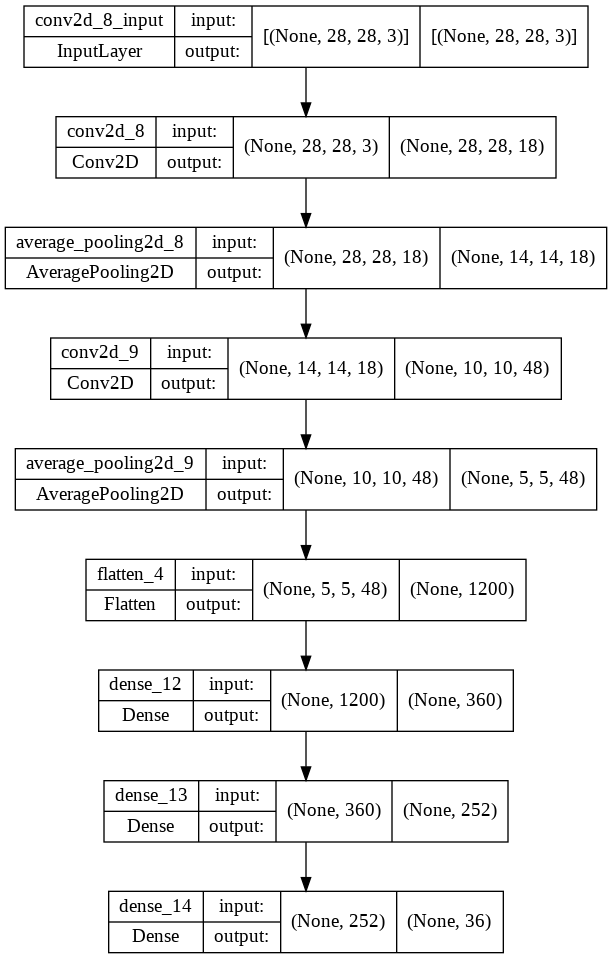

In [ ]:
# Visualize model layers
import pydotplus
import graphviz
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, show_shapes=True)

### 2.3 Train Model

In [ ]:
# Choose an architecture
model = CNN2.build()

# Prepare and train model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0003), metrics=['accuracy'])

import datetime
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

batch_size_divisor = 2
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)]

history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size_divisor,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size_divisor,
      epochs = 1000, callbacks=callbacks)

In [ ]:
# Training / validation process visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from statistics import mean

print("training acc ", mean(history.history['accuracy']))
print("validation acc ", mean(history.history['val_accuracy']))
print("training loss ", mean(history.history['loss']))
print("validation loss ", mean(history.history['val_loss']))

model.summary()

### 2.4 Export/Load Model

In [ ]:
# Export model
model.save('export\\CNN2.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('export\\CNN1.h5')

### 2.5 Essential Recognition Functions

Pre-processing functions together with detection and visualization.

In [ ]:
def extract_plate(plate_img): # the function detects and performs blurring on the number plate.
    input_tensor = tf.convert_to_tensor(np.expand_dims(plate_img, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    box = detections['detection_boxes'][0][0] # Take box with highest score

    width = plate_img.shape[1]
    height = plate_img.shape[0]

    roi = box*[height, width, height, width]
    plate = plate_img[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    
    return plate # returning the processed image.

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

def segment_characters(image, dbg=False) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    if dbg:
        plt.imshow(img_binary_lp, cmap='gray')
        plt.show()

        for i in range(len(char_list)):
            plt.subplot(1, 10, i+1)
            plt.imshow(char_list[i], cmap='gray')
            plt.axis('off')
        plt.show()

    return char_list

def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

DICTIONARY = {}
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i,c in enumerate(characters):
    DICTIONARY[i] = c

def show_results(char, model):
    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img), axis=-1)
        character = DICTIONARY[y_[0]]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

def visualize_result(char, plate_number):
    plt.figure(figsize=(10,6))
    for i,ch in enumerate(char):
        img = cv2.resize(ch, (28,28))
        plt.subplot(3,4,i+1)
        plt.imshow(img,cmap='gray')
        plt.title(f'predicted: {plate_number[i]}')
        plt.axis('off')
    plt.show()

def license_plate_det_n_recog_vis(image_path, model):
    image = cv2.imread(image_path)
    plate = extract_plate(image)
    char = segment_characters(plate)
    plate_number = show_results(char, model)
    print(f"Predicted Plate Number is: {plate_number}")
    visualize_result(char, plate_number)

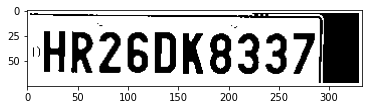

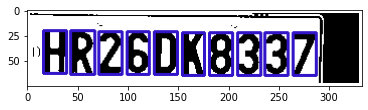

Predicted Plate Number is: HRZ6DK8337


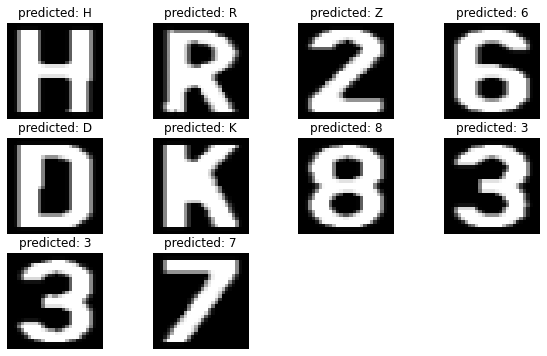

In [ ]:
model = tf.keras.models.load_model('export\\CNN1.h5')
path = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars425.png')
license_plate_det_n_recog_vis(path, model)

## 3 Real-Time Detection and Recognition

### 3.1 Recognition and Saving support functions

In [ ]:
def ocrfn(image):
    region = extract_plate(image)
    char = segment_characters(region)
    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(MODEL.predict(img), axis=-1)
        character = DICTIONARY[y_[0]] 
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    text = []
    text.append(plate_number)
    
    return text, region

#Save results function
#to save image name that is unique along with the detection result
import csv
import uuid

def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

### 3.2 Webcam Detection and Recognition Demo

For this part you need to train the detection model (chapter 1) and load saved recognition model below. The detection model is difficult to work with, so it is neccessary to train it according to the steps in this notebook.

Results are saved into specified file/folder of save_results function.

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

MODEL = tf.keras.models.load_model('export\\CNN1.h5')

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    if (num_detections > 0 and detections['detection_scores'][0] > .85):
        try: 
            text, region = ocrfn(image_np_with_detections)
            save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
        except:
            pass
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break